# Classification of ECG Diagnoses

Original Benchmarking Paper: &nbsp; [Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://ieeexplore.ieee.org/document/9190034)

Original Repository from Paper: &nbsp; [Repository on GitHub](https://github.com/helme/ecg_ptbxl_benchmarking)

Dataset: &nbsp; [PTB-XL, a large publicly available electrocardiography dataset](https://physionet.org/content/ptb-xl/1.0.3/)

# Import

In [1]:
from utils import utils

import sys
import os
import tqdm
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import torch
import fastai
import wfdb
import pickle

from models.fastai_model import fastai_model

from IPython.display import Image
from tabulate import tabulate

# Preprocessing

Before finetuning a pretrained model of the experiments we provide in our repository (or precomputed and provided [here](https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq)), first load your custom 100 Hz sampled 12-lead ECG signal data `X` of shape `[N,L,12]` in Millivolts (mV) and multi-hot encoded labels `y` of shape `[N,C]` as numpy arrays, where `C` is the number of classes and `N` the number of total samples in this dataset. Although PTB-XL comes with fixed `L=1000` (i,e. 10 seconds), it is not required to be fixed, **BUT** the shortest sample must be longer than `input_size` of the specific model (e.g. 2.5 seconds for our fastai-models).

For proper tinetuning split your data into four numpy arrays: `X_train`,`y_train`,`X_val` and `y_val`

Example: finetune model trained on all (71) on superdiagnostic (5)


Below we provide an example for loading [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/) aggregated at the `superdiagnostic` level, where we use the provided folds for train-validation-split:

## Load and aggregate data

In [2]:
experiment = 'exp1.1' # exp0. exp1.1, exp1.1.1
sampling_frequency = 100
datafolder = '../../data/ptbxl/'
task = 'superdiagnostic'
outputfolder_for_mlb = f'../output/{experiment}/'

# Load PTB-XL data
df, raw_labels = utils.load_dataset(datafolder, sampling_frequency)

# Preprocess label data
labels =  utils.compute_label_aggregations(raw_labels, datafolder, task)

# Select relevant data and convert to one-hot
X, Y, y, mlb =  utils.select_data(df, labels, task, min_samples=0, output_folder=outputfolder_for_mlb)

Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_codes_len,superdiagnostic,superdiagnostic_len
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,3,[NORM],1
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,2,[NORM],1
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,2,[NORM],1
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,2,[NORM],1
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,2,[NORM],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,4,[STTC],1
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,3,[NORM],1
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,2,[STTC],1


## Refactor classes for prediction (label manipulation)

In [3]:
all_class_names = list(mlb.classes_)
all_class_ids = [i for i, name in enumerate(all_class_names)]
num_all_classes = len(all_class_names)

print(f"All classes: {all_class_names}")
print(f'Class IDs: {all_class_ids}')
print(f"Count classes: {num_all_classes}")

All classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Class IDs: [0, 1, 2, 3, 4]
Count classes: 5


In [4]:
# classes_1 = ['MI'] # OTHER
# classes_2 = ['IMI'] # OTHER
# classes_3 = ['AMI'] # OTHER
# classes_4 = ['IMI', 'AMI'] # OTHER

In [5]:
# # extract excisting classes
# classes = classes_2
# class_ids = [i for i, name in enumerate(all_class_names) if name in classes]
# num_classes = len(classes)

# print(f"Classes to predict: {classes}")
# print(f'Class IDs: {class_ids}')
# print(f"Count classes: {num_classes}")

In [6]:
# # add new class
# new_classes = classes + ['OTHER']
# other_id = num_classes # ids start at zero, so we can use num_classes directly
# new_class_ids = class_ids + [other_id]
# num_new_classes = len(new_classes)


# print(f"Classes to predict: {new_classes}")
# print(f'Class IDs: {new_class_ids}')
# print(f"Count classes: {num_new_classes}")

In [7]:
# # label matrix containing zeros
# y_new = np.zeros((y.shape[0], num_new_classes))

# # fill new label matrix with existing classes
# for i, class_id in enumerate(class_ids):
#     y_new[:, i] = y[:, class_id]

# display(y_new)

In [8]:
# # true when at least one target class is present, false otherwise
# target_mask = y[:, class_ids].sum(axis=1) > 0

# # true when at least one label is present, false otherwise
# any_label_mask = y.sum(axis=1) > 0

# # fill new class with 1s where target classes are present
# other_mask = (~target_mask) & any_label_mask

# # set OTHER label to 1 where target classes are not present
# y_new[other_mask, other_id] = 1

# print(y_new)

In [9]:
print("Distribution of old labels:")

class_names = list(mlb.classes_)
num_classes = len(class_names)

percentage_all_samples = 0
for i, class_name in enumerate(class_names):
    count = (y[:, i] == 1).sum()
    percentage = count / y.shape[0] * 100 if y.shape[0] > 0 else 0
    percentage_all_samples += percentage
    print(f"{class_name}: {count} Samples ({percentage:.1f}%)")

print(f'∑ Samples: {y.shape[0]} ({percentage_all_samples:.1f}%) # Note: >100% due to multi-label')
print(f"\nSamples without any label: {(y.sum(axis=1) == 0).sum():.1f}")

Distribution of old labels:
CD: 4898 Samples (22.9%)
HYP: 2649 Samples (12.4%)
MI: 5469 Samples (25.6%)
NORM: 9514 Samples (44.5%)
STTC: 5235 Samples (24.5%)
∑ Samples: 21388 (129.8%) # Note: >100% due to multi-label

Samples without any label: 0.0


In [10]:
# print(f"\nDistribution of new labels:")

# percentage_all_samples = 0
# for i, class_name in enumerate(new_classes):
#     count = (y_new[:, i] == 1).sum()
#     percentage = count / y_new.shape[0] * 100
#     percentage_all_samples += percentage
#     print(f"{class_name}: {count} Samples ({percentage:.1f}%)")

# print(f'\n∑ Samples: {y_new.shape[0]} ({percentage_all_samples:.1f})%')
# print(f"∑ Samples without any label: {(y_new.sum(axis=1) == 0).sum():.1f}")

In [11]:
input_shape = X.shape[1:] # shape of samples, [None, 12] in case of different lengths
print(f'Input shape {input_shape} should be the same as (1000, 12)')

Input shape (1000, 12) should be the same as (1000, 12)


In [12]:
# update variables
class_names = all_class_names # new_classes 
num_classes = num_all_classes # num_new_classes # <=== number of classes in the finetuning dataset
#y = y_new

## Training, Validation and Testing Split

### Data Split

As written on physionet:

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

In [13]:
# 1-8 for training 
X_train = X[Y.strat_fold < 9]
y_train = y[Y.strat_fold < 9]

# 9 for validation
X_val = X[Y.strat_fold == 9]
y_val = y[Y.strat_fold == 9]

# 10 for testing
X_test = X[Y.strat_fold == 10]
y_test = y[Y.strat_fold == 10]

In [14]:
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

split_data = {
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'X Shape': [str(X_train.shape), str(X_val.shape), str(X_test.shape), f"({total_samples}, {X.shape[1]}, {X.shape[2]})"],
    'y Shape': [str(y_train.shape), str(y_val.shape), str(y_test.shape), f"({total_samples}, {y.shape[1]})"],
    'Samples': [X_train.shape[0], X_val.shape[0], X_test.shape[0], total_samples],
    'Percentage': [f"{X_train.shape[0]/total_samples*100:.1f}%", 
                   f"{X_val.shape[0]/total_samples*100:.1f}%", 
                   f"{X_test.shape[0]/total_samples*100:.1f}%", 
                   f"{(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])/total_samples*100:.1f}%"]
}

df_split = pd.DataFrame(split_data)
#print(tabulate(df_split, headers='keys', tablefmt='fancy_grid'))
display(df_split)

,Split,X Shape,y Shape,Samples,Percentage
0,Train,"(17084, 1000, 12)","(17084, 5)",17084,79.9%
1,Validation,"(2146, 1000, 12)","(2146, 5)",2146,10.0%
2,Test,"(2158, 1000, 12)","(2158, 5)",2158,10.1%
3,Total,"(21388, 1000, 12)","(21388, 5)",21388,100.0%


In [15]:
data = []
total_samples_all = y_train.shape[0] + y_val.shape[0] + y_test.shape[0]

for i, class_name in enumerate(class_names):
    train_count = (y_train[:, i] == 1).sum()
    val_count = (y_val[:, i] == 1).sum()
    test_count = (y_test[:, i] == 1).sum()
    total_count = train_count + val_count + test_count
    
    train_pct = train_count / y_train.shape[0] * 100
    val_pct = val_count / y_val.shape[0] * 100
    test_pct = test_count / y_test.shape[0] * 100
    total_pct = total_count / total_samples_all * 100
    
    data.append({
        'Class': class_name,
        'Train Count': train_count,
        'Train %': f"{train_pct:.1f}%",
        'Val Count': val_count,
        'Val %': f"{val_pct:.1f}%",
        'Test Count': test_count,
        'Test %': f"{test_pct:.1f}%",
        'Total Count': total_count,
        'Total %': f"{total_pct:.1f}%"
    })

# Add Total row
total_train = sum([(y_train[:, i] == 1).sum() for i in range(len(class_names))])
total_val = sum([(y_val[:, i] == 1).sum() for i in range(len(class_names))])
total_test = sum([(y_test[:, i] == 1).sum() for i in range(len(class_names))])
total_all = total_train + total_val + total_test

total_train_pct = total_train / y_train.shape[0] * 100
total_val_pct = total_val / y_val.shape[0] * 100
total_test_pct = total_test / y_test.shape[0] * 100
total_all_pct = total_all / total_samples_all * 100

data.append({
    'Class': 'TOTAL',
    'Train Count': total_train,
    'Train %': f"{total_train_pct:.1f}%",
    'Val Count': total_val,
    'Val %': f"{total_val_pct:.1f}%",
    'Test Count': total_test,
    'Test %': f"{total_test_pct:.1f}%",
    'Total Count': total_all,
    'Total %': f"{total_all_pct:.1f}%"
})

df_class_distribution = pd.DataFrame(data)
#print(tabulate(df_class_distribution, headers='keys', tablefmt='fancy_grid'))
display(df_class_distribution)

,Class,Train Count,Train %,Val Count,Val %,Test Count,Test %,Total Count,Total %
0,CD,3907,22.9%,495,23.1%,496,23.0%,4898,22.9%
1,HYP,2119,12.4%,268,12.5%,262,12.1%,2649,12.4%
2,MI,4379,25.6%,540,25.2%,550,25.5%,5469,25.6%
3,NORM,7596,44.5%,955,44.5%,963,44.6%,9514,44.5%
4,STTC,4186,24.5%,528,24.6%,521,24.1%,5235,24.5%
5,TOTAL,22187,129.9%,2786,129.8%,2792,129.4%,27765,129.8%


### Pretrained Standardizer

Since we standardize inputs to zero mean and unit variance, your custom data needs to be standardized with the respective mean and variance. This is also provided in the respective experiment folder `output/expX/data/standard_scaler.pkl`

In [16]:
standard_scaler = pickle.load(open(f'../output/{experiment}/data/standard_scaler.pkl', "rb"))

In [17]:
X_train = utils.apply_standardizer(X_train, standard_scaler)
X_val = utils.apply_standardizer(X_val, standard_scaler)
X_test = utils.apply_standardizer(X_test, standard_scaler)

# Load pretrained model

In [18]:
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output/'+experiment+'/models/'+modelname+'/'
outputfolder = '../output/'

if experiment=='exp0':
    n_classes_pretrained = 71
elif experiment=='exp1.1':
    n_classes_pretrained = 23
elif experiment=='exp1.1.1':
    n_classes_pretrained = 5
else:
    print(f'Experiment {experiment} not supported for this code snippet.')


print(f'Pretrainedfolder: {pretrainedfolder}')
print(f'Outputfolder: {outputfolder}')
print(f'Classes in pretrained model: {n_classes_pretrained}')
print(f'Classes in finetuning dataset: {num_classes}')

Pretrainedfolder: ../output/exp1.1/models/fastai_xresnet1d101/
Outputfolder: ../output/
Classes in pretrained model: 23
Classes in finetuning dataset: 5


In [19]:
model = fastai_model(
    modelname, 
    n_classes = num_classes, # <=== number of classes in the finetuning dataset
    freq = sampling_frequency, 
    outputfolder = outputfolder,  # <=== output folder for the finetuning model
    input_shape = input_shape, 
    loss = 'cross_entropy',
    pretrainedfolder = pretrainedfolder,
    n_classes_pretrained = n_classes_pretrained,
    pretrained = True,
    epochs_finetuning = 2,
)

In [20]:
print("="*60)
print("FASTAI MODEL PARAMETERS")
print("="*60)

print(f"Model name: {model.name}")
print(f"Number of classes: {model.num_classes}")
print(f"Input shape: {model.input_shape}")
print(f"Input size: {model.input_size}")
print(f"Input channels: {model.input_channels}")
print(f"Target frequency: {model.target_fs}")
print(f"Batch size: {model.bs}")

print(f"\nTraining parameters:")
print(f"Learning rate: {model.lr}")
print(f"Weight decay: {model.wd}")
print(f"Loss function: {model.loss}")
print(f"Epochs: {model.epochs}")
print(f"Epochs finetuning: {model.epochs_finetuning}")

print(f"\nPretrained model parameters:")
print(f"Pretrained classes: {model.n_classes_pretrained}")
print(f"Pretrained folder: {model.pretrainedfolder}")

print(f"\nData processing parameters:")
print(f"Chunk length train: {model.chunk_length_train}")
print(f"Chunk length valid: {model.chunk_length_valid}")
print(f"Stride length train: {model.stride_length_train}")
print(f"Stride length valid: {model.stride_length_valid}")

# Wichtigste Überprüfung: Stimmen die Klassen überein?
print("\n" + "="*60)
print("CLASS COMPATIBILITY CHECK")
print("="*60)
print(f"Your data classes: {num_classes}")
print(f"Model classes: {model.num_classes}")
print(f"Pretrained classes: {model.n_classes_pretrained}")

if model.num_classes == num_classes:
    print("✓ Model classes match your data classes")
elif model.num_classes == model.n_classes_pretrained:
    print("⚠️ Model still has pretrained number of classes")
    print("This might be intentional if you're using transfer learning")
else:
    print("✗ Model classes do NOT match your data or pretrained classes")

FASTAI MODEL PARAMETERS
Model name: fastai_xresnet1d101
Number of classes: 5
Input shape: (1000, 12)
Input size: 250
Input channels: 12
Target frequency: 100
Batch size: 128

Training parameters:
Learning rate: 0.01
Weight decay: 0.01
Loss function: cross_entropy
Epochs: 50
Epochs finetuning: 2

Pretrained model parameters:
Pretrained classes: 23
Pretrained folder: ..\output\exp1.1\models\fastai_xresnet1d101

Data processing parameters:
Chunk length train: 500
Chunk length valid: 250
Stride length train: 250
Stride length valid: 125

CLASS COMPATIBILITY CHECK
Your data classes: 5
Model classes: 5
Pretrained classes: 23
✓ Model classes match your data classes


# Finetune model

Calling `model.fit` of a model with `pretrained=True` will perform finetuning as proposed in our work i.e. **gradual unfreezing and discriminative learning rates**. 

In [21]:
model.fit(X_train, y_train, X_val, y_val)

Finetuning...
model: fastai_xresnet1d101


c:\Users\AliceKitchkin\miniconda3\envs\ecg_benchmarking_env\Lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sou

epoch,train_loss,valid_loss,time


c:\Users\AliceKitchkin\miniconda3\envs\ecg_benchmarking_env\Lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sou

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,1.127108,1.174983,03:14
1,1.028104,1.189235,03:04


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.985771,1.177989,03:20
1,0.983547,1.174664,03:19


# Evaluate model on validation data

In [22]:
y_val_pred = model.predict(X_val)

results = utils.generate_results(np.arange(len(y_val)), y_true=y_val, y_pred=y_val_pred, thresholds=None)
display(results)

model: fastai_xresnet1d101


aggregating predictions...


,macro_auc
0,0.92471


## Plots

In [23]:
threshold = 0.5
y_val_binary = y_val.astype(int)
y_pred_binary = (y_val_pred > threshold).astype(int)

Ausgewählte Labels: ['NORM', 'IMI', 'AMI', 'PMI', 'LMI', 'MI']
Warnung: Folgende Labels sind nicht verfügbar: ['IMI', 'AMI', 'PMI', 'LMI']


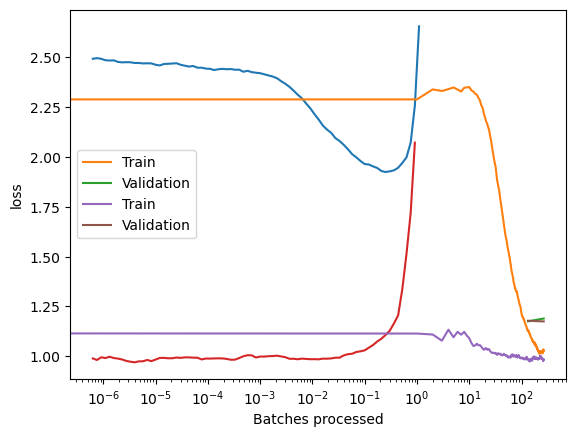

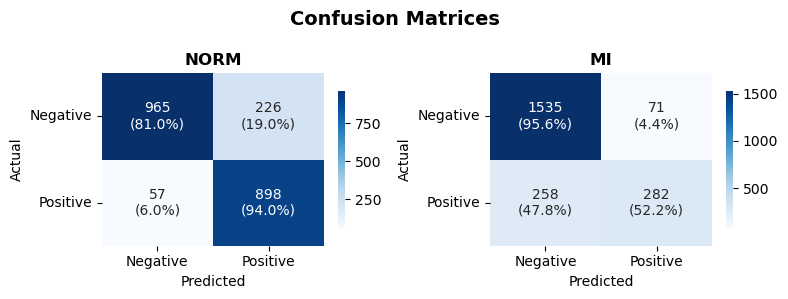


Alle Labels:


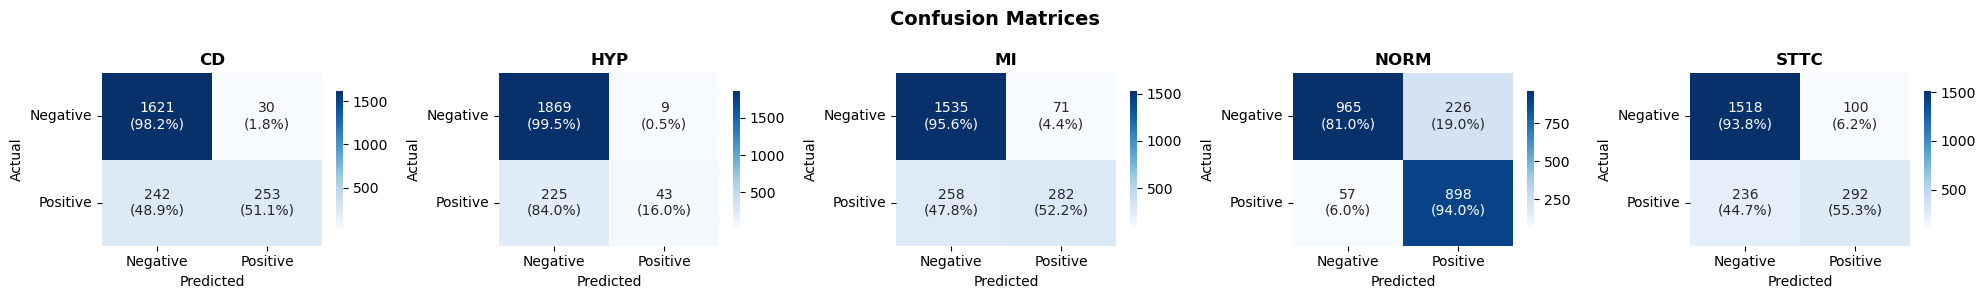

In [24]:
%matplotlib inline

def plot_confusion_matrices(y_true_binary, y_pred_binary, class_names, selected_labels=None, figsize_per_plot=(4, 3)):
    """
    Erstellt Confusion Matrix Heatmaps für ausgewählte Labels
    
    Parameters:
    y_true_binary: Binary true labels
    y_pred_binary: Binary predicted labels  
    class_names: Liste aller Klassennamen
    selected_labels: Liste der gewünschten Labels (None = alle Labels)
    figsize_per_plot: Größe pro einzelner Matrix (width, height)
    """
    
    if selected_labels is None:
        selected_labels = class_names
    
    # Validierung der Labels
    invalid_labels = [label for label in selected_labels if label not in class_names]
    if invalid_labels:
        print(f"Warnung: Folgende Labels sind nicht verfügbar: {invalid_labels}")
        selected_labels = [label for label in selected_labels if label in class_names]
    
    if len(selected_labels) == 0:
        print("Keine gültigen Labels ausgewählt!")
        return
    
    # Dynamische Berechnung der Grid-Größe
    import math
    num_selected = len(selected_labels)
    cols = min(6, num_selected)  # Maximal 6 Spalten
    rows = math.ceil(num_selected / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_per_plot[0], rows * figsize_per_plot[1]))
    
    # Flatten axes array für einfacheren Zugriff
    if num_selected == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    for i, label in enumerate(selected_labels):
        # Index des Labels finden
        label_idx = class_names.index(label)
        
        # Confusion Matrix berechnen
        cm = confusion_matrix(y_true_binary[:, label_idx], y_pred_binary[:, label_idx])
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        # Kombiniere absolute Zahlen und Prozentzahlen
        labels = np.asarray([f'{v1}\n({v2:.1f}%)' 
                            for v1, v2 in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2)
        
        # Heatmap erstellen
        sns.heatmap(cm, annot=labels, fmt='', ax=axes[i], cmap='Blues', 
                   cbar_kws={'shrink': 0.8})
        axes[i].set_title(f'{label}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('Actual', fontsize=10)
        
        # Achsenbeschriftungen für bessere Lesbarkeit
        axes[i].set_xticklabels(['Negative', 'Positive'], rotation=0)
        axes[i].set_yticklabels(['Negative', 'Positive'], rotation=0)
    
    # Verstecke leere Subplots
    for j in range(num_selected, rows * cols):
        if j < len(axes):
            axes[j].set_visible(False)
    
    plt.suptitle(f'Confusion Matrices', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Nur bestimmte Labels auswählen
selected_labels = ['NORM', 'IMI', 'AMI', 'PMI', 'LMI', 'MI']
print(f"Ausgewählte Labels: {selected_labels}")
plot_confusion_matrices(y_val_binary, y_pred_binary, class_names, selected_labels)

# Alle Labels
print("\nAlle Labels:")
plot_confusion_matrices(y_val_binary, y_pred_binary, class_names, None)

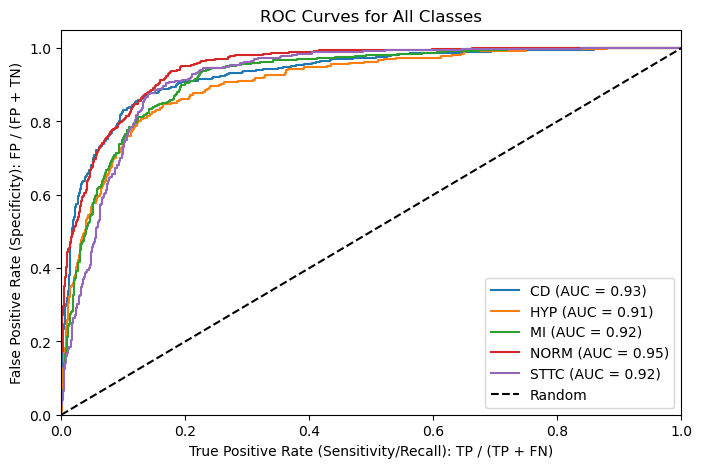

In [25]:
%matplotlib inline

plt.figure(figsize=(8, 5))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Positive Rate (Sensitivity/Recall): TP / (TP + FN)')
plt.ylabel('False Positive Rate (Specificity): FP / (FP + TN)')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.show()